Тестовая надпись

In [1]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
db_config = {'user': 'student',
             'pwd': 'qweasd963', 
             'host': '89.208.197.76', 'port': 5432,
             'db': 'simulative'} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],  db_config['pwd'],  
                                                         db_config['host'],  db_config['port'],  
                                                         db_config['db'])

In [3]:
engine = create_engine(connection_string) 

In [4]:
#Количество купленных подсказок и решений, а также в среднем на 1 пользователя.
bought_sol_hint = '''
WITH podskazka as(
    SELECT user_id, 
           COUNT(t.type_id) as cnt_podskazka 
    FROM "transaction" t
    JOIN users u ON u.id = t.user_id 
    WHERE t.value <=500 
    AND u.id > 94 
    AND t.type_id = 24 
    GROUP BY 1),
reshenie as(
    SELECT user_id, 
           COUNT(t.type_id) as cnt_reshenie 
    FROM "transaction" t
    JOIN users u on u.id = t.user_id 
    WHERE t.value <=500 
    AND u.id > 94 
    AND t.type_id = 25
    GROUP BY 1)
SELECT ROUND(AVG(cnt_podskazka), 2) as avg_podskazok, 
       SUM(cnt_podskazka) as sum_podskazok,
       ROUND(AVG(cnt_reshenie), 2) as avg_resheniy, 
       SUM(cnt_reshenie) as sum_resheniy 
FROM podskazka p
FULL JOIN reshenie r ON r.user_id = p.user_id
'''
pd.io.sql.read_sql(bought_sol_hint, con = engine)

,avg_podskazok,sum_podskazok,avg_resheniy,sum_resheniy
0,2.16,106.0,2.58,377.0


In [5]:
#смотрим распределение баланса с перцентилем 0.1
balance = '''
WITH balance as(
    SELECT t.user_id, 
           SUM(t.value)*-1 as value 
    FROM "transaction" t
    JOIN users u ON u.id = t.user_id 
    WHERE t.value <=500 
    AND u.id > 94 
    AND t.type_id BETWEEN 23 AND 27
    GROUP BY 1
    UNION
    SELECT t.user_id, 
           SUM(t.value) as value 
    FROM "transaction" t
    JOIN users u ON u.id = t.user_id 
    WHERE t.value <=500 
    AND u.id > 94 
    AND t.type_id BETWEEN 2 AND 22
    GROUP BY 1),
prep as(
    SELECT user_id, 
           sum(value) as balance 
    FROM balance 
    GROUP BY 1 
    HAVING SUM(value)>0)
SELECT percentile_disc(0) WITHIN GROUP (ORDER BY balance) as "0.0", 
       percentile_disc(0.1) WITHIN GROUP (ORDER BY balance) as "0.1",
       percentile_disc(0.2) WITHIN GROUP (ORDER BY balance) as "0.2",
       percentile_disc(0.3) WITHIN GROUP (ORDER BY balance) as "0.3",
       percentile_disc(0.4) WITHIN GROUP (ORDER BY balance) as "0.4",
       percentile_disc(0.5) WITHIN GROUP (ORDER BY balance) as "0.5",
       percentile_disc(0.6) WITHIN GROUP (ORDER BY balance) as "0.6",
       percentile_disc(0.7) WITHIN GROUP (ORDER BY balance) as "0.7",
       percentile_disc(0.8) WITHIN GROUP (ORDER BY balance) as "0.8",
       percentile_disc(0.9) WITHIN GROUP (ORDER BY balance) as "0.9",
       percentile_disc(1) WITHIN GROUP (ORDER BY balance) as "1.0"
FROM prep
'''
pd.io.sql.read_sql(balance, con = engine)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1.0,26.0,53.0,53.0,53.0,61.0,77.0,93.0,103.0,131.0,2216.0


In [6]:
DAU = '''
SELECT TO_CHAR(entry_at, 'Mon-dd') as day,
       COUNT(DISTINCT user_id) as DAU
FROM userentry
WHERE user_id > 94
GROUP BY day
'''
pd.io.sql.read_sql(DAU, con = engine)

,day,dau
0,Apr-01,44
1,Apr-02,28
2,Apr-03,31
3,Apr-04,44
4,Apr-05,44
...,...,...
180,Nov-26,28
181,Nov-27,25
182,Nov-28,22
183,Nov-29,28


In [7]:
WAU = '''
SELECT TO_CHAR(entry_at, 'YY-WW') as week,
       COUNT(DISTINCT user_id) as WAU
FROM userentry
WHERE user_id > 94
GROUP BY week
'''
pd.io.sql.read_sql(WAU, con = engine)

,week,wau
0,21-47,133
1,21-48,93
2,21-49,85
3,21-50,73
4,21-51,89
5,21-52,61
6,21-53,7
7,22-01,60
8,22-02,133
9,22-03,181


In [8]:
MAU = '''
SELECT TO_CHAR(entry_at, 'YYYY Mon') as month,
       COUNT(DISTINCT user_id) as MAU
FROM userentry
WHERE user_id > 94
GROUP BY month
'''
pd.io.sql.read_sql(MAU, con = engine)

,month,mau
0,2021 Dec,195
1,2021 Nov,174
2,2022 Apr,530
3,2022 Feb,1057
4,2022 Jan,579
5,2022 Mar,570
6,2022 May,432


<AxesSubplot:xlabel='day', ylabel='activ'>

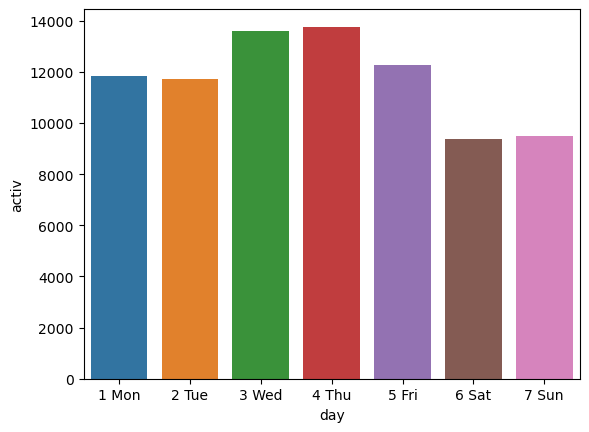

In [9]:
#Распределение активности по дням недели
Week_Activity = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart)
SELECT TO_CHAR(created_at, 'ID Dy') as day,
       COUNT(user_id) as activ
FROM activity
GROUP BY 1
'''
wa = pd.io.sql.read_sql(Week_Activity, con = engine)
sns.barplot(data=wa, x="day", y="activ")

<AxesSubplot:xlabel='hour', ylabel='activ'>

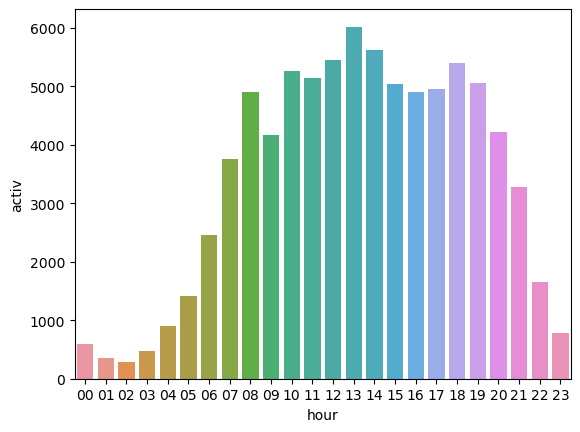

In [10]:
#Распределение активности по времени суток
Hours_Activity = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart)
SELECT TO_CHAR(created_at, 'HH24') as hour,
       COUNT(user_id) as activ
FROM activity
GROUP BY 1
'''
ha = pd.io.sql.read_sql(Hours_Activity, con = engine)
sns.barplot(data=ha, x="hour", y="activ")

In [11]:
#какой % заходов не сопровождается активностью.
Activity_Check = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart), 
prep as(
    SELECT ue.user_id, 
           CASE WHEN ac.user_id IS NULL THEN 1 ELSE 0 END is_not_active 
    FROM userentry ue
    LEFT JOIN activity ac 
    ON TO_CHAR(ue.entry_at, 'YY-MM-DD HH24-MI') = TO_CHAR(ac.created_at, 'YY-MM-DD HH24-MI')
    AND ac.user_id = ue.user_id 
    JOIN users us ON ue.user_id = us.id)
SELECT ROUND(SUM(is_not_active)/COUNT(is_not_active)::numeric*100, 2) as procent 
FROM prep
'''
pd.io.sql.read_sql(Activity_Check, con = engine)

,procent
0,68.44


In [13]:
NDay_Retention = '''
WITH prep as(
    SELECT TO_CHAR(u2.date_joined, 'MM') as month, 
           EXTRACT(days FROM u.entry_at-u2.date_joined) as diff,
           COUNT(DISTINCT user_id) as total 
    FROM userentry u
    JOIN users u2 ON u2.id = u.user_id
    WHERE TO_CHAR(u2.date_joined, 'YYYY') = '2022'
    AND extract(days from u.entry_at - u2.date_joined) IN (0, 1, 3, 7, 14, 30)
    GROUP BY month, diff)
SELECT TO_CHAR(TO_DATE(month, 'MM'), 'Month') as month,
       MAX(CASE WHEN diff = 0 THEN total END) as "0",
       MAX(CASE WHEN diff = 1 THEN total END) as "1",
       MAX(CASE WHEN diff = 3 THEN total END) as "3",
       MAX(CASE WHEN diff = 7 THEN total END) as "7",
       MAX(CASE WHEN diff = 14 THEN total END) as "14",
       MAX(CASE WHEN diff = 30 THEN total END) as "30"
FROM prep
GROUP BY month
'''
pd.io.sql.read_sql(NDay_Retention, con = engine)

,month,0,1,3,7,14,30
0,January,481,84,45,27,24,6
1,February,883,94,41,22,12,5
2,March,411,44,32,12,7,4
3,April,203,33,30,15,12,5


In [14]:
NDay_Retention_percent = '''
WITH prep as(
    SELECT TO_CHAR(u2.date_joined, 'MM') as month, 
           EXTRACT(days FROM u.entry_at-u2.date_joined) as diff,
           COUNT(DISTINCT user_id) as total 
    FROM userentry u
    JOIN users u2 ON u2.id = u.user_id
    WHERE TO_CHAR(u2.date_joined, 'YYYY') = '2022'
    AND extract(days from u.entry_at - u2.date_joined) IN (0, 1, 3, 7, 14, 30)
    GROUP BY month, diff),
prep2 as(
    SELECT TO_CHAR(TO_DATE(month, 'MM'), 'Month') as month,
           MAX(CASE WHEN diff = 0 THEN total END) as "0",
           MAX(CASE WHEN diff = 1 THEN total END) as "1",
           MAX(CASE WHEN diff = 3 THEN total END) as "3",
           MAX(CASE WHEN diff = 7 THEN total END) as "7",
           MAX(CASE WHEN diff = 14 THEN total END) as "14",
           MAX(CASE WHEN diff = 30 THEN total END) as "30"
    FROM prep
GROUP BY month)
SELECT month, MAX("0")/MAX("0")*100.0 as "0",
       ROUND(MAX("1")/MAX("0")::numeric*100, 2) as "1",
       ROUND(MAX("3")/MAX("0")::numeric*100, 2) as "3",
       ROUND(MAX("7")/MAX("0")::numeric*100, 2) as "7",
       ROUND(MAX("14")/MAX("0")::numeric*100, 2) as "14",
       ROUND(MAX("30")/MAX("0")::numeric*100, 2) as "30"
FROM prep2
GROUP BY month
'''
pd.io.sql.read_sql(NDay_Retention_percent, con = engine)

,month,0,1,3,7,14,30
0,April,100.0,16.26,14.78,7.39,5.91,2.46
1,February,100.0,10.65,4.64,2.49,1.36,0.57
2,January,100.0,17.46,9.36,5.61,4.99,1.25
3,March,100.0,10.71,7.79,2.92,1.70,0.97


In [15]:
Rolling_Retention = '''
WITH prep as(
    SELECT u2.user_id, 
           TO_CHAR(u.date_joined, 'Month') as month, 
           MAX(DATE(u2.entry_at)-DATE(u.date_joined)) as diff
    FROM users u
    JOIN userentry u2 ON u.id = u2.user_id
    WHERE TO_CHAR(u.date_joined, 'YYYY') = '2022'
    GROUP BY u2.user_id, month),
prep2 as(
    SELECT month, user_id,
           MAX(CASE WHEN diff >= 0 THEN 1 END) as "0",
           MAX(CASE WHEN diff >= 1 THEN 1 END) as "1",
           MAX(CASE WHEN diff >= 3 THEN 1 END) as "3",
           MAX(CASE WHEN diff >= 7 THEN 1 END) as "7",
           MAX(CASE WHEN diff >= 14 THEN 1 END) as "14",
           MAX(CASE WHEN diff >= 30 THEN 1 END) as "30"
    FROM prep
    GROUP BY month, user_id),
prep3 as(
    SELECT month, 
           SUM("0") as "0",
           SUM("1") as "1",
           SUM("3") as "3",
           SUM("7") as "7",
           SUM("14") as "14",
           SUM("30") as "30"
    FROM prep2
    GROUP BY month)
SELECT * FROM prep3
'''
pd.io.sql.read_sql(Rolling_Retention, con = engine)

,month,0,1,3,7,14,30
0,April,208,99,76,61,46,22
1,February,891,292,212,147,115,85
2,January,498,222,184,151,126,77
3,March,415,144,109,77,60,35


In [16]:
Rolling_Retention_percent = '''
WITH prep as(
    SELECT u2.user_id, 
           TO_CHAR(u.date_joined, 'Month') as month, 
           MAX(DATE(u2.entry_at)-DATE(u.date_joined)) as diff
    FROM users u
    JOIN userentry u2 ON u.id = u2.user_id
    WHERE TO_CHAR(u.date_joined, 'YYYY') = '2022'
    GROUP BY u2.user_id, month),
prep2 as(
    SELECT month, user_id,
           MAX(CASE WHEN diff >= 0 THEN 1 END) as "0",
           MAX(CASE WHEN diff >= 1 THEN 1 END) as "1",
           MAX(CASE WHEN diff >= 3 THEN 1 END) as "3",
           MAX(CASE WHEN diff >= 7 THEN 1 END) as "7",
           MAX(CASE WHEN diff >= 14 THEN 1 END) as "14",
           MAX(CASE WHEN diff >= 30 THEN 1 END) as "30"
    FROM prep
    GROUP BY month, user_id),
prep3 as(
    SELECT month, 
           SUM("0") as "0",
           SUM("1") as "1",
           SUM("3") as "3",
           SUM("7") as "7",
           SUM("14") as "14",
           SUM("30") as "30"
    FROM prep2
    GROUP BY month)
SELECT month, MAX("0")/MAX("0")*100.0 as "0",
       ROUND(MAX("1")/MAX("0")::numeric*100, 2) as "1",
       ROUND(MAX("3")/MAX("0")::numeric*100, 2) as "3",
       ROUND(MAX("7")/MAX("0")::numeric*100, 2) as "7",
       ROUND(MAX("14")/MAX("0")::numeric*100, 2) as "14",
       ROUND(MAX("30")/MAX("0")::numeric*100, 2) as "30"
FROM prep3
GROUP BY month
'''
pd.io.sql.read_sql(Rolling_Retention_percent, con = engine)

,month,0,1,3,7,14,30
0,April,100.0,47.60,36.54,29.33,22.12,10.58
1,February,100.0,32.77,23.79,16.50,12.91,9.54
2,January,100.0,44.58,36.95,30.32,25.30,15.46
3,March,100.0,34.70,26.27,18.55,14.46,8.43
